In [ ]:
import cv2
import numpy as np
from skimage import io, exposure, img_as_ubyte, img_as_float
from skimage.filters import threshold_otsu
from scipy.ndimage import label, median_filter
import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.measure import EllipseModel

In [2]:
def apply_percentile_threshold(image_data, percentile=99.7):
    threshold_value = np.percentile(image_data, percentile)
    
    return np.clip(image_data, None, threshold_value)

In [3]:
def apply_adaptive_filtering(image_data, size=3):
    return median_filter(image_data, size=size)

Text(0.5, 1.0, 'Raw image')

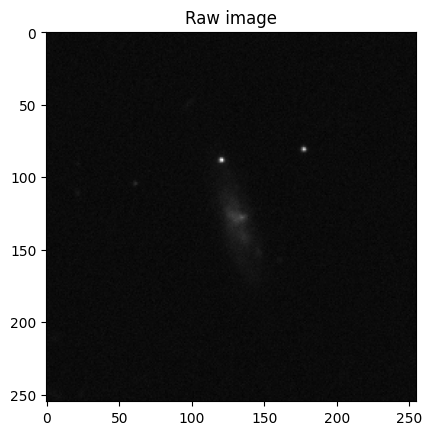

In [4]:
image_path = './../dataset/g/PGC0000451_g.fits'
hdu_list = fits.open(image_path)
image = hdu_list[0].data


# Normalisation de l'image
image = img_as_float(image)
image /= np.max(image)

plt.imshow(image, cmap='gray')
plt.title('Raw image')

Text(0.5, 1.0, 'Thresholded image 99.7%')

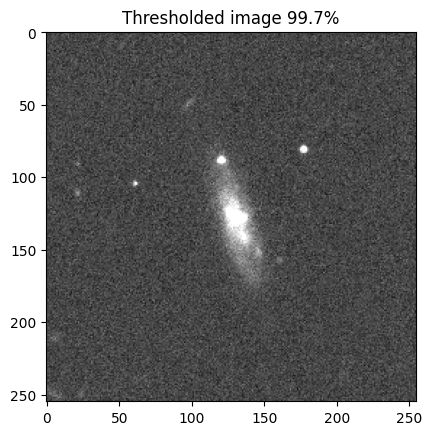

In [5]:
image_thresholded = apply_percentile_threshold(image)
plt.imshow(image_thresholded, cmap='gray')
plt.title('Thresholded image 99.7%')

Text(0.5, 1.0, 'Adaptive filtering')

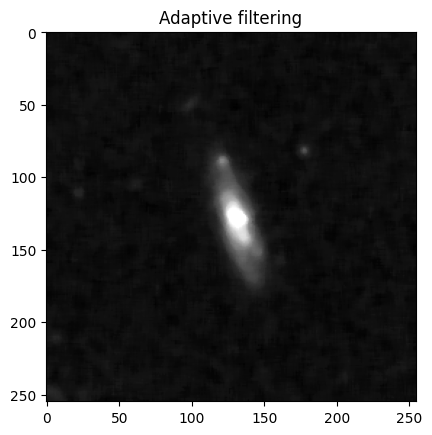

In [6]:
lisser = apply_adaptive_filtering(image_thresholded, size=8)
plt.imshow(lisser, cmap='gray')
plt.title('Adaptive filtering')

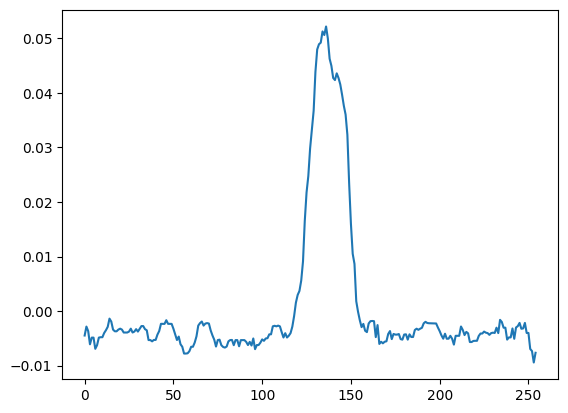

In [7]:
plt.plot(lisser[150], label='Adaptive filtering')

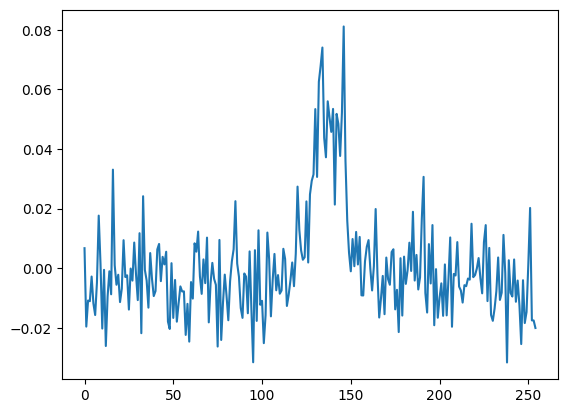

In [8]:
plt.plot(image_thresholded[150], label='Thresholded image 99.7%')

[[127 112]
 [127 147]
 [128 112]
 ...
 [253   1]
 [213   0]
 [252   0]]
((131.49686933448854, 132.50274544436027), (53.19919125509112, 18.69536861594327), 1.235904580618554)


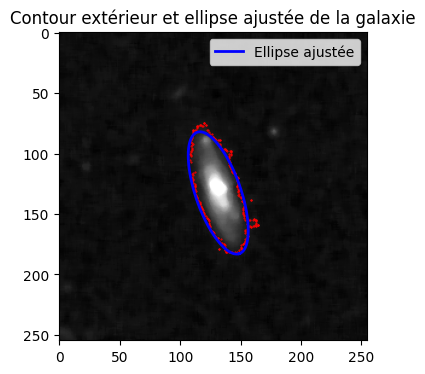

In [40]:
def normalize_image(image):
    """Normalise l'image pour faciliter le traitement."""
    return cv2.normalize(image.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)


def detect_edges_in_profile(profile, threshold):
    """Détecte les bords gauche et droit d'un profil horizontal ou vertical."""
    left_edge = np.argmax(profile > threshold)
    right_edge = len(profile) - np.argmax(profile[::-1] > threshold) - 1
    return left_edge, right_edge


def find_contour_points(image, center_y, center_x, threshold):
    """Trouve tous les points de contour dans les directions Y et X."""
    contour_points = []
    
    # Trouver les points de contour dans la direction Y (haut et bas)
    for y in range(center_y, image.shape[0]):
        profile = image[y, :]
        left_edge, right_edge = detect_edges_in_profile(profile, threshold)
        contour_points.append((y, left_edge))
        contour_points.append((y, right_edge))
    
    for y in range(center_y, -1, -1):
        profile = image[y, :]
        left_edge, right_edge = detect_edges_in_profile(profile, threshold)
        contour_points.append((y, left_edge))
        contour_points.append((y, right_edge))
    
    # Trouver les points de contour dans la direction X (gauche et droite)
    for x in range(center_x, image.shape[1]):
        profile = image[:, x]
        top_edge, bottom_edge = detect_edges_in_profile(profile, threshold)
        contour_points.append((top_edge, x))
        contour_points.append((bottom_edge, x))
    
    for x in range(center_x, -1, -1):
        profile = image[:, x]
        top_edge, bottom_edge = detect_edges_in_profile(profile, threshold)
        contour_points.append((top_edge, x))
        contour_points.append((bottom_edge, x))
    
    return np.array(contour_points)


def group_contour_points(contour_points, max_distance=10):
    """Regroupe les points de contour en fonction de leur proximité."""
    groups = []
    visited = np.zeros(len(contour_points), dtype=bool)
    
    def euclidean_distance(p1, p2):
        """Calcule la distance euclidienne entre deux points."""
        return np.sqrt(np.sum((np.array(p1) - np.array(p2))**2))

    for i, point in enumerate(contour_points):
        if visited[i]:
            continue
        # Créer un nouveau groupe
        group = [point]
        visited[i] = True
        
        # Chercher les voisins de ce point pour les ajouter au groupe
        stack = [point]
        while stack:
            p = stack.pop()
            for j, q in enumerate(contour_points):
                if not visited[j] and euclidean_distance(p, q) < max_distance:
                    group.append(q)
                    visited[j] = True
                    stack.append(q)
        
        # Ajouter le groupe trouvé
        groups.append(np.array(group))
    
    return groups


def select_group_near_center(groups, center_y, center_x):
    """Sélectionne le groupe le plus proche du centre de l'image."""
    min_distance = float('inf')
    selected_group = None
    
    for group in groups:
        distances = np.linalg.norm(group - np.array([center_y, center_x]), axis=1)
        avg_distance = np.mean(distances)
        
        if avg_distance < min_distance:
            min_distance = avg_distance
            selected_group = group
    
    return selected_group


def fit_ellipse_to_contour(contour_points):
    """Ajuste une ellipse aux points de contour."""
    if len(contour_points) >= 5:
        # Convertir les points en un format approprié pour EllipseModel
        group_y, group_x = zip(*contour_points)
        
        # Ajuster l'ellipse aux points du groupe
        ellipse = EllipseModel()
        ellipse.estimate(np.column_stack((group_x, group_y)))

        # Obtenir les paramètres de l'ellipse ajustée
        yc, xc, a, b, theta = ellipse.params

        # Retourner les paramètres sous la forme demandée
        return (xc, yc), (a, b), theta
    else:
        print("Pas assez de points pour ajuster une ellipse.")
        return None


def plot_contour_and_ellipse(image, contour_points, ellipse):
    """Affiche l'image avec le contour détecté et l'ellipse ajustée."""
    plt.figure(figsize=(4, 4))
    plt.imshow(image, cmap='gray')
    plt.plot(contour_points[:, 1], contour_points[:, 0], 'r.', markersize=1)
    
    # Extraire les paramètres de l'ellipse ajustée
    ellipse_center = ellipse[0]
    ellipse_axes = ellipse[1]
    ellipse_angle = ellipse[2]
    
    # Générer les points de l'ellipse ajustée
    t = np.linspace(0, 2 * np.pi, 100)
    xc, yc = ellipse_center
    a, b = ellipse_axes
    theta = ellipse_angle
    
    ellipse_x = xc + a * np.cos(t) * np.cos(theta) - b * np.sin(t) * np.sin(theta)
    ellipse_y = yc + a * np.cos(t) * np.sin(theta) + b * np.sin(t) * np.cos(theta)
    
    # Afficher l'ellipse ajustée
    plt.plot(ellipse_x, ellipse_y, color='blue', linewidth=2, label='Ellipse ajustée')
    
    plt.title("Contour extérieur et ellipse ajustée de la galaxie")
    plt.legend()
    plt.show()


def detect_contour_with_ellipse(image, max_distance=10, threshold=0.1):
    """Fonction principale pour détecter les contours et ajuster une ellipse."""
    norm_image = normalize_image(image)
    
    # Calculer les coordonnées centrales
    center_y, center_x = np.array(norm_image.shape) // 2
    
    # Trouver les points de contour dans les directions Y et X
    contour_points = find_contour_points(norm_image, center_y, center_x, threshold)
    print(contour_points)
    # Sauvegarder les points de contour dans un fichier texte
    np.savetxt('contour_points.txt', contour_points, fmt='%d', delimiter=',')
    
    # Regrouper les points voisins
    groups = group_contour_points(contour_points, max_distance)
    
    # Sélectionner le groupe proche du centre
    selected_group = select_group_near_center(groups, center_y, center_x)
    
    if selected_group is not None:
        # Ajuster l'ellipse
        ellipse = fit_ellipse_to_contour(selected_group)
        print(ellipse)
        if ellipse:
            plot_contour_and_ellipse(norm_image, selected_group, ellipse)
    else:
        print("Aucun groupe trouvé près du centre.")


detect_contour_with_ellipse(lisser, max_distance=10, threshold=0.1)